In [ ]:
!pip install yfinance --quiet
!pip install yahooquery --quiet
!pip install requests_html --quiet
!pip install ydata_profiling --quiet
!pip install PyPortfolioOpt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 86.7 MB/s et

In [ ]:
# Modules imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
from yahooquery import Screener
import requests
from requests_html import HTMLSession
from datetime import datetime
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

# The goal
Inspired by the G-Reseach competition in [Kaggle](https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview) and [this portfolio optimizer tool](https://www.portfoliovisualizer.com/optimize-portfolio)

Our aim is to create a Streamlit App to generate, for a given:
  - Porfolio of crypto-currencies.
  - Budget.

The optimized ratio of chosen currencies by maximizing the Sharpe Ratio

We begin the exercice with a step by step guided notebook to cover all the inner working of task completion before wrapping everything in **App.py** script.

# The Data

We'll start with a selection of 5 most popular crypto currencies by market capitalization.

## Getting Data

For scraping historical trading data of the crypto currencies, we rely on Yahoo! finance API.
Fortunatly there is a python [project](https://pypi.org/project/yfinance/) who offers an easy pythonic way to get data.

In [ ]:
# Scraping list of 5 most popular crypto tickets (cc)

session = HTMLSession()
num_currencies=5
resp = session.get(f"https://finance.yahoo.com/crypto?offset=0&count={num_currencies}")
tables = pd.read_html(resp.html.raw_html)               
df = tables[0].copy()
cc = df.Symbol.tolist()
cc

['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'USDC-USD']

In [ ]:
# For the given cryptocurrencies, we grab the daily histrical closing price data since 2020:

tickers = yf.Tickers(cc)
end_date = datetime.now().strftime('%Y-%m-%d')
data = tickers.history(start='2020-01-01',end=end_date,interval='1d')['Close']
data

[*********************100%***********************]  5 of 5 completed


,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
Date,,,,,
2020-01-01,13.689083,7200.174316,130.802002,1.004079,0.999836
2020-01-02,13.027011,6985.470215,127.410179,1.005017,1.001565
2020-01-03,13.660452,7344.884277,134.171707,1.005273,1.004192
2020-01-04,13.891512,7410.656738,135.069366,1.009466,1.007472
2020-01-05,14.111019,7411.317383,136.276779,1.008497,1.006197
...,...,...,...,...,...
2023-04-24,331.245880,27525.339844,1842.757446,1.000042,1.000121
2023-04-25,338.325562,28307.597656,1866.753662,1.000000,1.000159
2023-04-26,330.821777,28422.701172,1866.564209,0.999884,1.000282


## Preprocessing Data

In [ ]:
# missing data
data.isna().sum()

BNB-USD     0
BTC-USD     0
ETH-USD     0
USDC-USD    0
USDT-USD    0
dtype: int64

In [ ]:
data.dtypes

BNB-USD     float64
BTC-USD     float64
ETH-USD     float64
USDC-USD    float64
USDT-USD    float64
dtype: object

In [ ]:
#data = data.dropna()

In [ ]:
#data.isna().sum()

Other than missing values, it seems there is no issues with observations to handle, we save the downloaded data as a csv file for future exploitation.

# EDA

Having no issues with data, the next step is to explore their main statistical features.

In [ ]:
data.describe()

,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
count,1214.000000,1214.000000,1214.000000,1214.000000,1214.000000
mean,247.655233,28452.543677,1687.546299,1.000641,1.000588
std,181.317329,16362.185222,1210.152394,0.004095,0.002551
min,9.386050,4970.788086,110.605873,0.970124,0.974248
25%,28.530031,13576.421631,430.487167,0.999886,1.000021
50%,284.238358,23635.012695,1583.482361,1.000062,1.000260
75%,371.872993,41562.748047,2561.279785,1.000331,1.000800
max,675.684082,67566.828125,4812.087402,1.044029,1.053585


And distributions.

<Axes: >

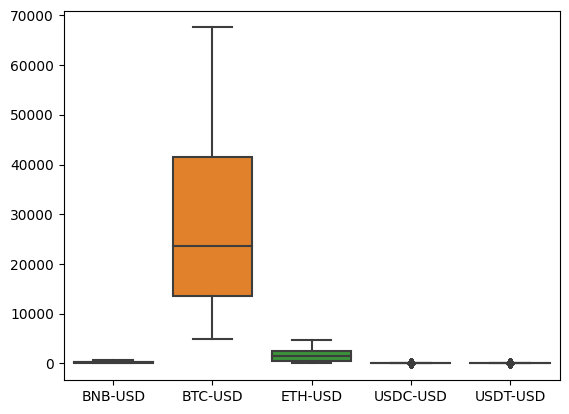

In [ ]:
sns.boxplot(data)

Switching to logaritimic scale (base 2) for more visibility.

<Axes: >

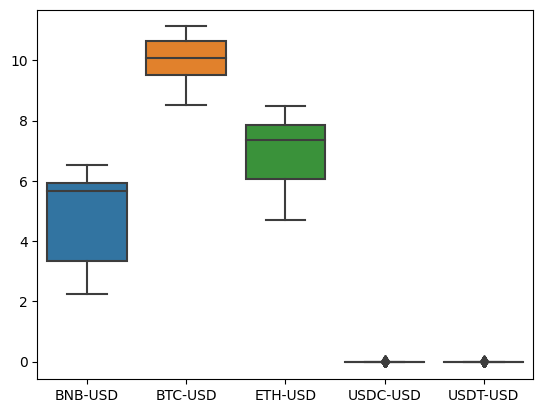

In [ ]:
log_data = np.log(data)
sns.boxplot(log_data)

It seems we have two groups of currencices.

But before jumping to conclusions, let's inspect the relation between each two currencies.

## Correlation Analysis

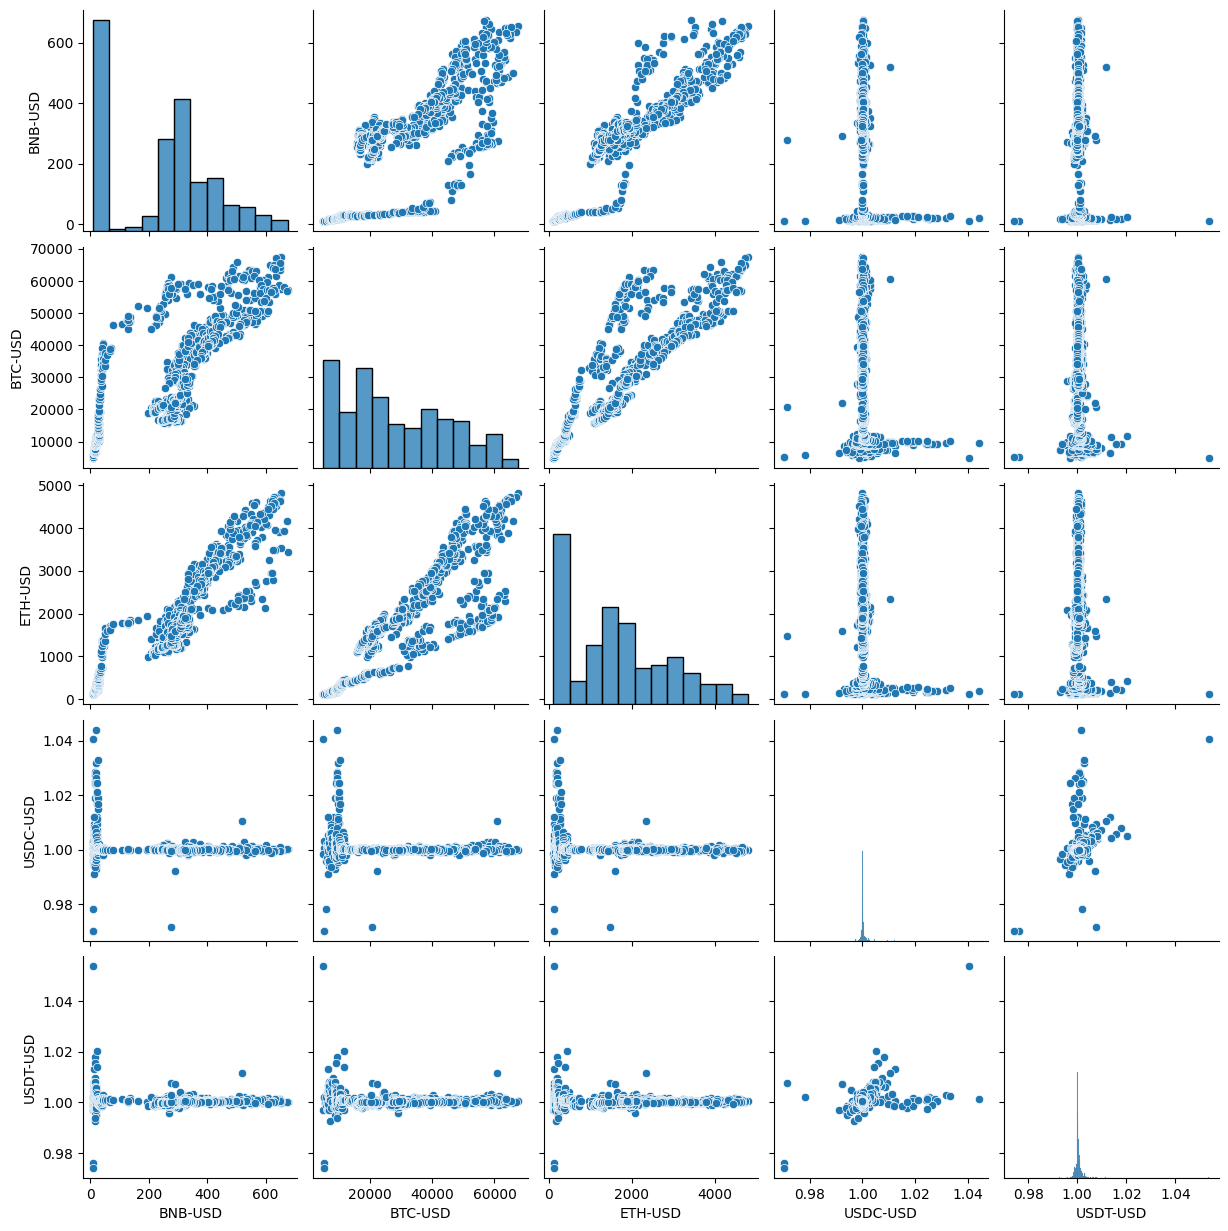

In [ ]:
# Ploting each two currencies at a time
sns.pairplot(data)

<Axes: >

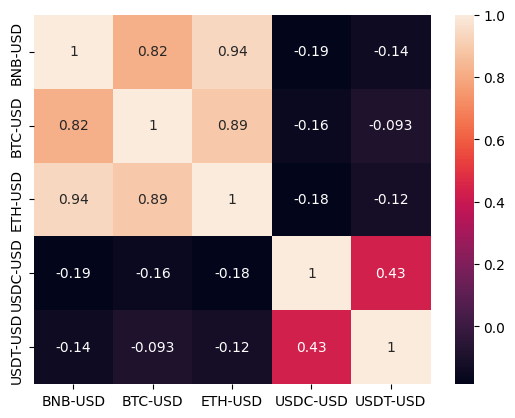

In [ ]:
# Calculating and visualizing the correlation between each two currency
corr = data.corr()
sns.heatmap(corr, annot=True)

Indeed, two groups of hight and low correlated currencies.

## Volatility Analysis

In finance, mesuring volatilty is assessing how much of a fluctuating an asset is, and the more an asset is volatile, the riskier it is and more difficult to predict.

In [ ]:
df = data.copy()

In [ ]:
df = np.log(df/df.shift()).rolling(window=365).std()*365**.5

Unlike stock markets where we do specify 252 days of trading per year.

Crypto markets are 24/7 traded throughtout the year.

The choice of 365 days of rolling window is to calculate the annualized volatility.

In [ ]:
df = df.dropna()

In [ ]:
df

,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
Date,,,,,
2020-12-31,0.974188,0.766632,1.001485,0.106998,0.106501
2021-01-01,0.972838,0.765921,1.001114,0.106994,0.106495
2021-01-02,0.971830,0.769314,1.001467,0.106994,0.106470
2021-01-03,0.974283,0.769468,1.026627,0.106913,0.106420
2021-01-04,0.974236,0.770008,1.028306,0.106909,0.106413
...,...,...,...,...,...
2023-04-24,0.679382,0.615041,0.827216,0.036261,0.008795
2023-04-25,0.679592,0.615187,0.826775,0.036260,0.008793
2023-04-26,0.678295,0.612391,0.823971,0.036260,0.008794


In [ ]:
import plotly.graph_objects as go
def plot_graph(col,title,xlabel,ylabel,df):
    data = []
    for i in range(len(col)): 
        plot = go.Scatter(x=df.index,y=df[col[i]], name=col[i])
        data.append(plot)
    
    layout = go.Layout(title= title ,
                    xaxis=dict(title=xlabel),
                    yaxis=dict(title=ylabel ), 
                    width = 690, 
                    height = 500, 
                    autosize = True)

    fig = go.Figure(data=data, layout=layout)
    
    fig.show()
    
title = "Annualized Volatility Plot"
xlabel = 'Date'
ylabel = 'Closing prive volatility'
df = df
col = list(data.columns.values)

plot_graph(col,title,xlabel,ylabel,df)

We Can identify two groups of correlated currencies:


*   Hight Volatility/Positive correlated currencies consisted of:
    1.   BitCoin (BTC)
    2.   Etherium (ETH)
    3.   Binance Coin (BNB)


*   Low Volatility/Negative correlated set of:
    1.   USD Coin (USDC)
    2.   Tether (USDT)


# Modeling
For the modeling section, we rely on Mean-variance optimization (MVO) solution provided by PyPortfolioOpt Library.

The MVO solution is constrained by maximizing the Sharpe ratio which is reputable to indicate how well the risk-ajusted performance a portfolio can be.

The higher the ratio (preferably above 1) the better investment decision is.





In [ ]:
# Calculating the mean historical return and covariance matrices
mu = mean_historical_return(data)
S = CovarianceShrinkage(data).ledoit_wolf()

In [ ]:
mu

BNB-USD     0.930289
BTC-USD     0.338913
ETH-USD     0.742118
USDC-USD   -0.000867
USDT-USD    0.000179
dtype: float64

In [ ]:
S

,BNB-USD,BTC-USD,ETH-USD,USDC-USD,USDT-USD
BNB-USD,0.744228,0.335954,0.453920,-0.002978,-0.005662
BTC-USD,0.335954,0.345847,0.366717,-0.002296,-0.004724
ETH-USD,0.453920,0.366717,0.594097,-0.003628,-0.006367
USDC-USD,-0.002978,-0.002296,-0.003628,0.010096,0.001862
USDT-USD,-0.005662,-0.004724,-0.006367,0.001862,0.009826


The risk free market is corresponding to the US Federal Reserve Interest Rate.

In [ ]:
# Scrapping the current FED interest rate
all_data = pd.read_html('https://www.global-rates.com/en/interest-rates/central-banks/central-bank-america/fed-interest-rate.aspx')
FED = [df for df in all_data if df.iloc[0][0] == 'American interest rate (Fed)'][0].iloc[0][1]
# Formating into float
FED = float(FED[:5])/100

In [ ]:
FED

0.05

In [ ]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe(risk_free_rate= FED)
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('BNB-USD', 0.64384), ('BTC-USD', 0.0), ('ETH-USD', 0.35616), ('USDC-USD', 0.0), ('USDT-USD', 0.0)])


In [ ]:
ef.portfolio_performance(verbose=True, risk_free_rate = FED)

Expected annual return: 86.3%
Annual volatility: 76.9%
Sharpe Ratio: 1.06


(0.8632689703332141, 0.7694423466438537, 1.0569589442022822)

# Insights Visualization

This section is preliminary implementation of portfolio backtesting.

But first, let explore visually the optimization results in terms of efficients frontier vis-a-vis a randomized set of portfolios.

## Modeling Results

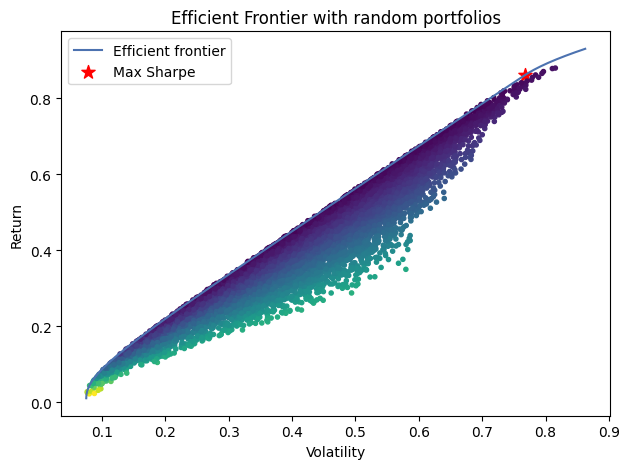

In [ ]:
from pypfopt import plotting as pt
fig, ax = plt.subplots()
ef = EfficientFrontier(mu, S)
pt.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

Again, The maximized Sharpe-Ratio (which is an indication of how well the risk-ajusted performance a portfolio can be) is corresponding to a Portfolio with the following ratios:

In [ ]:
# Optimized Portfolio ratios 
labels = [i for i in cleaned_weights.keys() if cleaned_weights[i] != 0]
sizes = [i for i in cleaned_weights.values() if i != 0]
optimized_portfolio = pd.DataFrame([i for i in zip(labels, sizes)], columns=['Tickers','Ratio'])
optimized_portfolio

,Tickers,Ratio
0,BNB-USD,0.64384
1,ETH-USD,0.35616


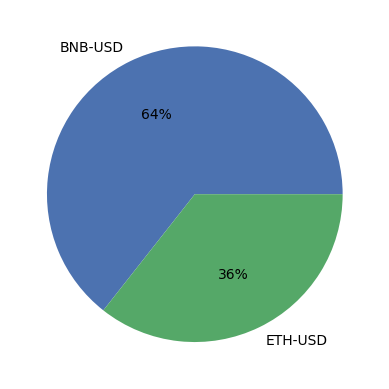

In [69]:
# Optimized Portfolio ratios 
plt.pie(sizes, labels=labels, autopct='%.0f%%')
plt.show()

## Portfolio Perfomance

In [ ]:
# distributed
# annulized
# cummulative
# ----> returns
# of two portfolios:
## Optimized ratio
## Equalized ratio

# Portfolio (E&O) value growth

In [ ]:
#https://github.com/kdboller/pythonsp500/blob/master/Investment%20Portfolio%20Python%20Notebook_03_2018_blog%20example.ipynb

Now the Optimized Portfolio consisted of the following assets/ratios

In [ ]:
optimized_portfolio

,Tickers,Ratio
0,BNB-USD,0.64384
1,ETH-USD,0.35616


We start with the daily portfolio return by calling the pct_change attribute in pandas library.

In [71]:
daily_return = pd.DataFrame()

In [72]:
for i in labels:
  daily_return[f'{i}'] = data[i].pct_change()[1:]

In [73]:
daily_return

,BNB-USD,ETH-USD
Date,,
2020-01-02,-0.048365,-0.025931
2020-01-03,0.048625,0.053069
2020-01-04,0.016915,0.006690
2020-01-05,0.015802,0.008939
2020-01-06,0.060009,0.058905
...,...,...
2023-04-24,0.001897,-0.010367
2023-04-25,0.021373,0.013022
2023-04-26,-0.022179,-0.000101


<Axes: xlabel='Date'>

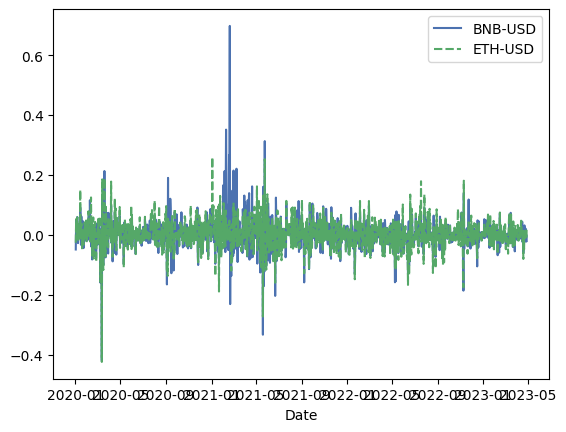

In [74]:
sns.lineplot(daily_return)

And according to the optimized ratio, we compute the Portfolio daily revenue 

In [ ]:
select_assets['Total_Opt_returns'] = select_assets['daily_return_BNB-USD']*.65 + select_assets['daily_return_ETH-USD'] * .35

In [ ]:
select_assets.head()

,daily_return_BNB-USD,daily_return_ETH-USD,Total_Opt_returns
Date,,,
2020-01-01,NaN,NaN,NaN
2020-01-02,-0.048365,-0.025931,-0.040513
2020-01-03,0.048625,0.053069,0.050181
2020-01-04,0.016915,0.006690,0.013336
2020-01-05,0.015802,0.008939,0.013400


<Axes: xlabel='Date', ylabel='Total_Opt_returns'>

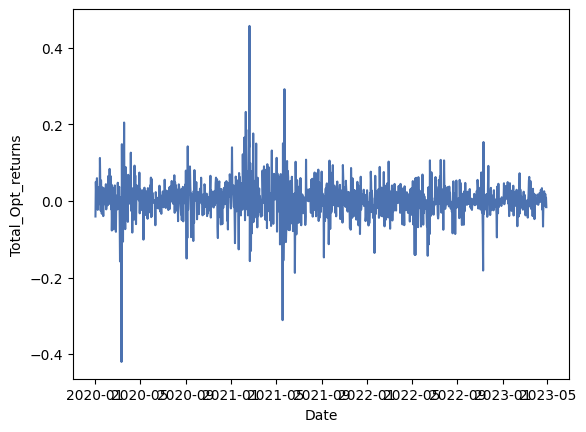

In [ ]:
sns.lineplot(select_assets['Total_Opt_returns'])

Then we continue with the cumulative returns.

In [ ]:
select_assets['total_cumluative_return'] = select_assets['Total_Opt_returns'].cumsum().pct_change()

In [ ]:
select_assets.tail()

,daily_return_BNB-USD,daily_return_ETH-USD,Total_Opt_returns,total_cumluative_return
Date,,,,
2023-04-24,0.001897,-0.010367,-0.002396,-0.000513
2023-04-25,0.021373,0.013022,0.018450,0.003955
2023-04-26,-0.022179,-0.000101,-0.014452,-0.003085
2023-04-27,0.001128,0.022620,0.008651,0.001853
2023-04-28,-0.020214,-0.008526,-0.016123,-0.003446


Por

In [ ]:
#https://www.investopedia.com/terms/c/cumulativereturn.asp
#https://www.codingfinance.com/post/2018-04-05-portfolio-returns-py/
#https://jatinkathiriya.medium.com/python-portfolio-backtesting-and-visualization-a99bcc5de230
#https://colab.research.google.com/gist/jatinkathiriya/ca9063711316d9b7c3cbd993b8c6656b/portfolio-backtesting.ipynb

In [ ]:
#Portfolio return vs Equi return

In [ ]:
#Template

# Porfolio perfomance

## Optimized Portfolio
  # Values & Growth
  # Profits&Loss Generated
  
## Base line Porfolio
  #-> A Portfolio with equal ratios
  # Values & Growth
  # Profits&Loss Generated

## Comparaison
  # Value&Growth
  # Profit&Loss
  

# Streamlit App

Wrapping all previous steps into a Streamlit App

In [ ]:
# Template
# https://streamlit-example-app-download-app-lk16x1.streamlit.app/

# Design
"""
Title [CryptoPortOpt] AKA Crypto Currencies Porfolio' Optimizer

Step1: Select Your Porfolio
  -> The user will be provider with a list of  10 most popular
  crypto by market cap

Step2: Budget(Optional)
  ->  Default to 1000 USA for Porfolio Performation 
  visualizations

Step3: Optimize using MVO/PyPortOpt
  -> Maximize Sharpe Ratio
  Or
  -> Minimise Volatility

Step4: Results/Visualisation
  -> Asset Allocations
  -> Portfolio Performance
"""

In [ ]:
# modules required to run the App
%%writefile requirements.txt
pandas
matplotlib
seaborn
numpy
yfinance
yahooquery
requests
requests_html
datetime
pypfopt

In [ ]:
#%%writefile app.py


# Conclusion

Beyond the App
- Portfolio builder App

# References
[Getting Crypto Symbols](https://stackoverflow.com/a/74656748)

[Portfolio Optimization Using Python](https://github.com/areed1192/portfolio-optimization/blob/master/samples/portfolio_optimization.ipynb)

[Portfolio Builder](https://github.com/yeungadrian/PortfolioBuilder)

[Portfolio Selection with Graph Algorithms and Deep Learning](https://www.linkedin.com/pulse/portfolio-selection-graph-algorithms-deep-learning-maya-benowitz)

[G-Research Crypto Forecasting](https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview)

[G-Research Crypto Forecasting](https://www.kaggle.com/code/cstein06/tutorial-to-the-g-research-crypto-competition/notebook#Preprocessing)

[yfinance guide](https://www.qmr.ai/yfinance-library-the-definitive-guide/#Fetch_Historical_Prices_using_yfinance
)

[Portfolio Optimization with PyPortfolioOpt](https://github.com/paulsg3/PortfolioOptimization/blob/main/Portfolio_Optimization.ipynb)

[PyPortfolioOpt Documentation](https://pyportfolioopt.readthedocs.io/en/latest/)

[Portfolio Optimization using Reinforcement Learning](https://github.com/kvsnoufal/portfolio-optimization)

[Multi-level Columns](https://stackoverflow.com/a/56080234)

[On the non-stationarity of financial time series: Impact on optimal portfolio selection](https://www.researchgate.net/publication/224905259_On_the_non-stationarity_of_financial_time_series_Impact_on_optimal_portfolio_selection)

[Stationary TS](https://analyticsindiamag.com/how-to-make-a-time-series-stationary/)

[Volatility Analysis](https://www.learnpythonwithrune.org/calculate-the-volatility-of-historic-stock-prices-with-pandas-and-python/)

[Volatility Analysis](https://blog.quantinsti.com/volatility-and-measures-of-risk-adjusted-return-based-on-volatility/)

[Sharpe Ratio](https://www.investopedia.com/terms/s/sharperatio.asp)

[Mean-variance Optimization](https://www.investopedia.com/terms/m/meanvariance-analysis.asp)

[Backtesting](https://gist.github.com/jatinkathiriya/ca9063711316d9b7c3cbd993b8c6656b#file-portfolio-backtesting-ipynb)